### Import

In [38]:
# Libraries
import sys
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
from tqdm import tqdm

# Files
from vehicle import *

In [5]:
# num_states = 2
# num_inputs = 2


# def mpc_control(
#     vehicle,
#     N,
#     x_init,
#     u_init,
#     x_target,
#     pos_constraints,
#     vel_constraints,
#     # acc_constraints,
#     obstacles,
#     move_obstacles,
#     last_plan,
#     max_vel=1,
#     v_max_penalty=100,
# ):
#     # Create an optimization problem
#     opti = ca.Opti()

#     # State & Input matrix
#     Q = np.eye(2) * 0.01
#     R = np.eye(2) * 0.001

#     # Define Variables
#     x = opti.variable(num_states, N + 1)
#     u = opti.variable(num_inputs, N)

#     # Initialize Cost & Constraints
#     cost = 0.0

#     # Init Constraint
#     opti.subject_to(x[:, 0] == x_init)

#     # Loop through time steps
#     for k in range(N):
#         # State Constraints
#         opti.subject_to(x[:, k] >= [pos_constraints[0], pos_constraints[2]])
#         opti.subject_to(x[:, k] <= [pos_constraints[1], pos_constraints[3]])
#         opti.subject_to(u[:, k] >= [vel_constraints[0], vel_constraints[2]])
#         opti.subject_to(u[:, k] <= [vel_constraints[1], vel_constraints[3]])

#         # Acceleration constraint
#         # TODO

#         for obstacle in obstacles:
#             euclid_distance = ca.norm_2(
#                 (x[0:2, k] - np.array(obstacle[0:2]).reshape(2, 1))
#                 + np.ones((2, 1)) * sys.float_info.epsilon
#             )
#             opti.subject_to(euclid_distance >= obstacle[2])
#             # cost += 100 / ((euclid_distance - obstacle[2]) ** 2 + sys.float_info.epsilon)

#         # Dynamics Constraint
#         opti.subject_to(x[:, k + 1] == vehicle.A @ x[:, k] + vehicle.B @ u[:, k])

#         # Cost function
#         e_k = ca.sqrt((x_target - x[:, k]) ** 2)
#         cost += ca.mtimes(e_k.T, Q @ e_k) + ca.mtimes(u[:, k].T, R @ u[:, k])

#     # Cost last state
#     e_N = ca.sqrt((x_target - x[:, -1]) ** 2)
#     cost += ca.mtimes(e_N.T, Q @ e_N) + ca.mtimes(u[:, -1].T, R @ u[:, -1])

#     # Warm start
#     if last_plan is not None:
#         opti.set_initial(x, last_plan)
#     else:
#         # Setup initial guess for states (interpolate between x_init and x_target)
#         for k in range(N + 1):
#             x_guess = x_init + (x_target - x_init) * k / N
#             # x_guess[6] = 0  # Set initial guess for speed in z direction to zero
#             opti.set_initial(x[:, k], x_guess)

#     # Define Problem in solver
#     opti.minimize(cost)

#     opts = {
#         "print_time": 0,
#         # "tol": 0.01,
#         # "gamma_theta": 1e-2
#     }  # Set the verbosity level (0-12, default is 5)
#     opti.solver(
#         "ipopt",
#         {
#             "ipopt.print_level": 0,
#             "print_time": 0,
#         },
#         opts,
#     )

#     # Run Solver
#     try:
#         # opti.callback(lambda i: print( opti.debug.value(x[:, :i]) ))
#         sol = opti.solve()
#         optimal_solution_u = sol.value(u)
#         optimal_solution_x = sol.value(x)
#         optimal_cost = sol.value(cost)
#         # print("Optimal cost:", optimal_cost)
#     except RuntimeError:
#         print("Solver failed to find a solution.")
#         opti.debug.show_infeasibilities()
#         x = opti.debug.value(x)
#         u = opti.debug.value(u)
#         return u[:, 0], x[:, 1], x, False

#     return optimal_solution_u[:, 0], optimal_solution_x[:, 1], optimal_solution_x, True

In [39]:
num_states = 2
num_inputs = 2


def mpc_control(
    vehicle,
    N,
    x_init,
    u_init,
    x_target,
    pos_constraints,
    vel_constraints,
    # acc_constraints,
    obstacles,
    move_obstacles,
    dt,
    last_plan,
    max_vel=1,
    v_max_penalty=100,
    tw = 1,
):
    assert tw//dt > 0
    assert tw//dt < N

    # Create an optimization problem
    opti = ca.Opti()

    # State & Input matrix
    Q = np.eye(2) * 0.04
    R = np.eye(2) * 0.06

    # Define Variables
    x = opti.variable(num_states, N + 1)
    u = opti.variable(num_inputs, N)

    # Initialize Cost & Constraints
    cost = 0.0
    constraints = []

    # Init Constraint
    constraints += [x[:, 0] == x_init]
    # constraints += [u[:, 0] == u_init]

    # Loop through time steps
    for k in range(N):
        # State Constraints
        constraints += [x[:, k] >= [pos_constraints[0], pos_constraints[2]]]
        constraints += [x[:, k] <= [pos_constraints[1], pos_constraints[3]]]
        # constraints += [u[:, k] >= [vel_constraints[0], vel_constraints[2]]]
        # constraints += [u[:, k] <= [vel_constraints[1], vel_constraints[3]]]

        for obstacle in obstacles:
            euclid_distance = ca.norm_2(
                x[0:2, k] - np.array(obstacle[0:2]).reshape(2, 1)
            )
            constraints += [euclid_distance >= obstacle[2] + 0.01]
            # cost += 100/((euclid_distance-obstacle[2])**2 + 0.01)

        # Dynamics Constraint
        constraints += [x[:, k + 1] == ((x[:, k] + dt * u[:, k - (tw//dt)]) if k - (tw//dt) >= 0 else x[:, k])]

        # Cost function
        e_k = x_target - x[:, k]
        cost += ca.mtimes(e_k.T, Q @ e_k) + ca.mtimes(u[:, k].T, R @ u[:, k])

    # Cost last state
    e_N = x_target - x[:, -1]
    cost += ca.mtimes(e_N.T, Q @ e_N) + ca.mtimes(u[:, -1].T, R @ u[:, -1])

    # Warm start
    if last_plan is not None:
        opti.set_initial(x, last_plan)
    else:
        # Setup initial guess for states (interpolate between x_init and x_target)
        for k in range(N + 1):
            x_guess = x_init + (x_target - x_init) * k * dt * 0.04
            opti.set_initial(x[:, k], x_guess)
    
    # def callback(i):
    #         # Print all contraint values
    #         print("Constraint values at iteration", i)
    #         for c in constraints:
    #             print(opti.debug.value(c))
                
    # opti.callback(callback)

    # Define Problem in solver
    opti.minimize(cost)
    opti.subject_to(constraints)

    opts = {
        "ipopt.print_level": 0,
        "print_time": 0,
    }  # Set the verbosity level (0-12, default is 5)
    opti.solver(
        "ipopt",
        opts,
        opts,
    )

    # Run Solver
    try:
        sol = opti.solve()
        optimal_solution_u = sol.value(u)
        optimal_solution_x = sol.value(x)
        # optimal_cost = sol.value(cost)
    except RuntimeError:
        print("Solver failed to find a solution.")
        opti.debug.x_describe(0)
        opti.debug.g_describe(0)

        # opti.debug.show_infeasibilities()
        x = opti.debug.value(x)
        u = opti.debug.value(u)
        return u[:, 0], x[:, 1], x, False

    return optimal_solution_u[:, 0], optimal_solution_x[:, 1], optimal_solution_x, True

In [41]:
def simulate(
    simulation_len,
    x_init,
    x_target,
    obstacles,  # [center_x, center_y, radius]
    dt,  # Time step [s]
    N,  # Time Horizon
    pos_constraints,  # Position Constraints [m]:    [x_min, x_max, y_min, y_max]
    vel_constraints,  # Velocity Constraints [m/s]:    [v_x_min, v_x_max, v_y_min, v_y_max]
    acc_constraints,  # Acceleration Constraints [m/s^2]:    [x_min, x_max, y_min, y_max]
    velocity_res,  # m/s
    acceleration,  # m/s^2
):
    vehicle = vehicle_SS(dt)

    ## Timesteps
    timesteps = np.arange(0, simulation_len, dt)
    print(f"Timesteps: {len(timesteps)}")

    # Initialise the output arrays
    x = np.zeros((num_states, len(timesteps) + 1))
    xdot = np.zeros((num_states, len(timesteps) + 1))
    u = np.zeros((num_inputs, len(timesteps)))
    plans = np.zeros((num_states, N + 1, len(timesteps)))

    initial_guess_x = None
    
    maxvel = 0.5

    x[:, 0] = np.array(x_init)
    x_target = np.array(x_target)
    for t in tqdm(range(len(timesteps)), total=len(timesteps)):
        # Compute the control input
        xdot_prev = xdot[:, max(0, t - 1)]
        u_out, _, plan, succ = mpc_control(
            vehicle=vehicle,
            N=N,
            x_init=x[:, t],
            u_init=xdot_prev,
            x_target=x_target,
            pos_constraints=pos_constraints,
            vel_constraints=vel_constraints,
            max_vel=maxvel,
            v_max_penalty=300,
            obstacles=obstacles,
            move_obstacles=[],
            last_plan=initial_guess_x,
            dt=dt,
            tw=5*dt,
        )
        u[:, t] = u_out
        plans[:, :, t] = plan
        initial_guess_x = plan
        
        if not succ:
            print(f"Failed to find a solution at t={t}")
            return x[:, :t+1], xdot[:, :t+1], u[:, :t+1], plans[:, :, :t+1], timesteps, obstacles

        # Apply the control input to the system
        u_diff = u_out - xdot[:, t]
        xdot[:, t + 1] = (
            xdot[:, t] + np.sign(u_diff) * acceleration * dt
            if np.linalg.norm(u_diff) > velocity_res
            else xdot[:, t]
        )
        # Clip the velocity magnitude
        speed = np.linalg.norm(xdot[:, t + 1])
        if speed > 0:
            clamped_speed = min(speed, maxvel)
            xdot[:, t + 1] = (xdot[:, t + 1] / speed) * clamped_speed
        x[:, t + 1] = xdot[:, t] * dt + x[:, t]

    return x, xdot, u, plans, timesteps, obstacles

In [42]:
pos_constraints = [
    -2,
    2,
    -2.5,
    2.5,
]
vel_constraints = [
    -0.08,
    0.08,
    -0.08,
    0.08,
]

x_init=[-1, -1]
x_target=[1, 1]
obstacles = np.array([[0.1, 0.1, 0.09]])

In [43]:
x, xdot, u, plans, timesteps, obstacles = simulate(
    simulation_len=30,
    x_init=x_init,
    x_target=x_target,
    obstacles=obstacles,
    dt=1 / 30,  # Time step [s]
    N=20,  # Time Horizon
    pos_constraints=pos_constraints,
    vel_constraints=vel_constraints,
    acc_constraints=[
        -1,
        1,
        -1,
        1,
    ],  # Acceleration Constraints [m/s^2]:    [x_min, x_max, y_min, y_max]
    velocity_res=0.0001,  # m/s
    acceleration=3,  # m/s^2
)

Timesteps: 900


 11%|█         | 96/900 [00:03<00:28, 28.62it/s]

Solver failed to find a solution.
Failed to find a solution at t=96


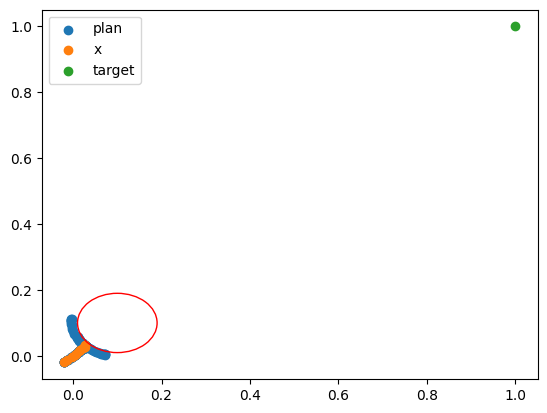

In [37]:
plt.scatter(plans[0, :, -10:], plans[1, :, -10:], label="plan")
plt.scatter(x[0, -10:], x[1, -10:], label="x")
plt.scatter(x_target[0], x_target[1], label="target")
# plt.scatter(obstacles[:, 0], obstacles[:, 1], label="obstacles")
# Draw the obstacles with radius
for i in range(len(obstacles)):
    plt.gca().add_patch(plt.Circle((obstacles[i, 0], obstacles[i, 1]), obstacles[i, 2], color='r', fill=False))
plt.legend()

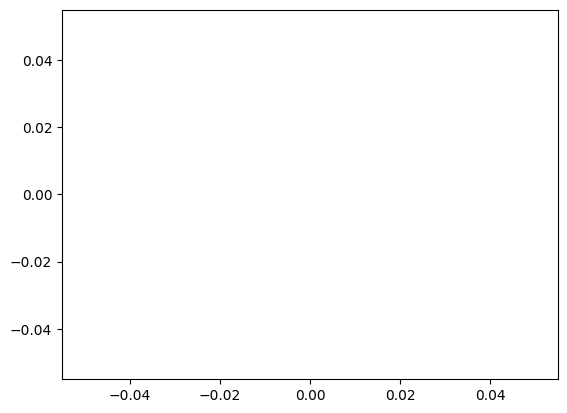

ValueError: attempt to get argmax of an empty sequence

In [40]:
# Calculate x slope
slope = np.linalg.norm((x[:, 1:] - x[:, :-1]), axis=0) / (1/30)
plt.plot(slope)
plt.show()
np.argmax(slope)

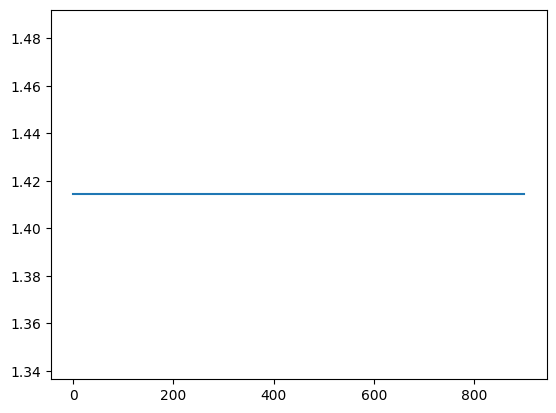

In [14]:
plt.plot(np.linalg.norm(x, axis=0))
plt.show()

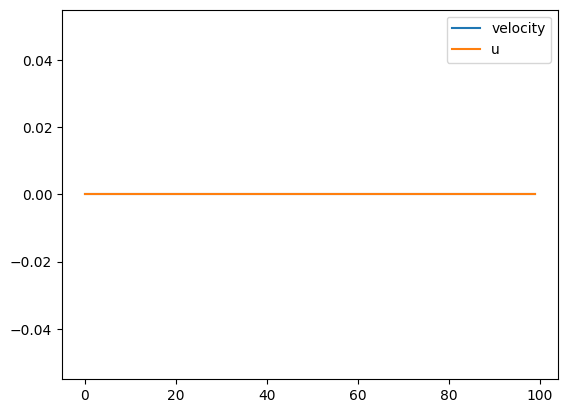

In [15]:
plt.plot(np.linalg.norm(xdot[:, -100:], axis=0), label="velocity")
plt.plot(np.linalg.norm(u[:, -100:], axis=0), label="u")
# plt.ylim(0, 0.075)
plt.legend()

Animation size has reached 20977754 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

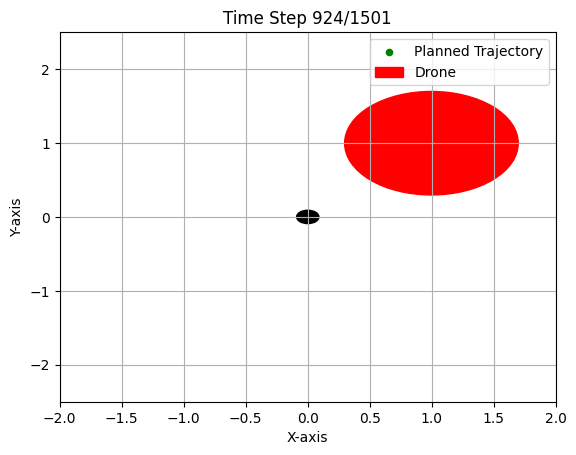

In [5]:
def update(frame):
    # Clear previous frame
    plt.cla()

    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    drone = plt.Circle((x[0][frame], x[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='k', fill=True)
        plt.gca().add_patch(circle)


    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(x[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(pos_constraints[0], pos_constraints[1])
    plt.ylim(pos_constraints[2], pos_constraints[3])
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(x[1]), interval=50)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
